# PROJECT: CREDIT RELIABILITY FOR CREDIT CARD ISSUANCE

# 1. Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_scoring.csv to credit_scoring.csv


In [ ]:
df = pd.read_csv('credit_scoring.csv')

In [ ]:
print(df.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0 

In [ ]:
df_info = {
    'columns': df.columns.to_list(),
    'missing values': df.isna().sum(),
    'shape': df.shape,
    'duplicated values': df.duplicated().sum()
}

for key,value in df_info.items():
  print(f'{key.capitalize()}')
  print(value)
  print('\n' + '*'*50 + '\n')

Columns
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'TARGET']

**************************************************

Missing values
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

*********************

In [ ]:
df.dropna(subset=["NAME_FAMILY_STATUS"], inplace=True)
df.drop(["ID"], axis= 1, inplace=True)

In [ ]:
df = df.drop_duplicates()
df.loc[(df["NAME_INCOME_TYPE"] == "Pensioner"),"OCCUPATION_TYPE"] = "Pensioner"
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Unknown")

# 2. Analysis

In [ ]:
_ = df['TARGET'].value_counts()
print(_)

TARGET
0    308704
1     29722
Name: count, dtype: int64


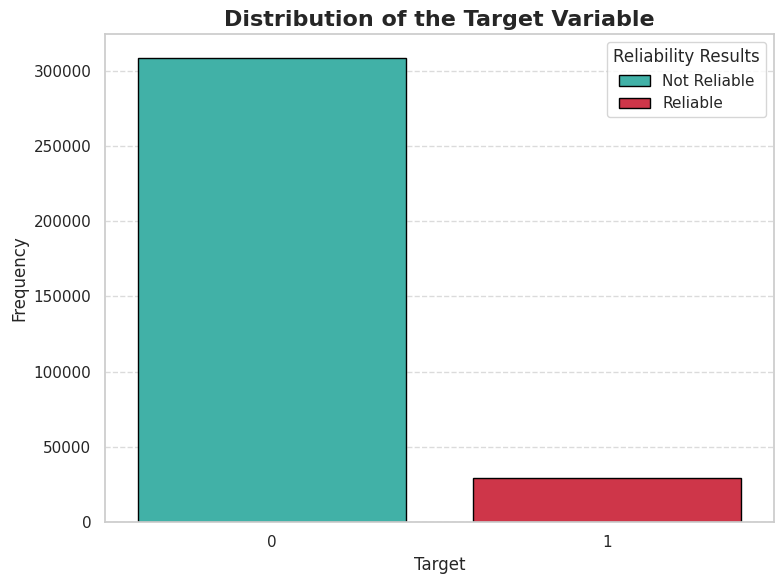

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x="TARGET", hue="TARGET",
                   palette=["#2ec4b6", "#e71d36"], edgecolor="black")

plt.title("Distribution of the Target Variable", fontsize=16, fontweight='bold')
plt.xlabel("Target", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Reliable", "Reliable"], title="Reliability Results", loc='upper right')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

From the first analysis of the dataset, it emerges that 90% of the observations belong to class 0 and the remaining 10% to class 1.

In [ ]:
cgt = df.groupby(["CODE_GENDER","TARGET"]).size().reset_index(name="count")
print(cgt)

  CODE_GENDER  TARGET   count
0           F       0  208567
1           F       1   19348
2           M       0  100137
3           M       1   10374


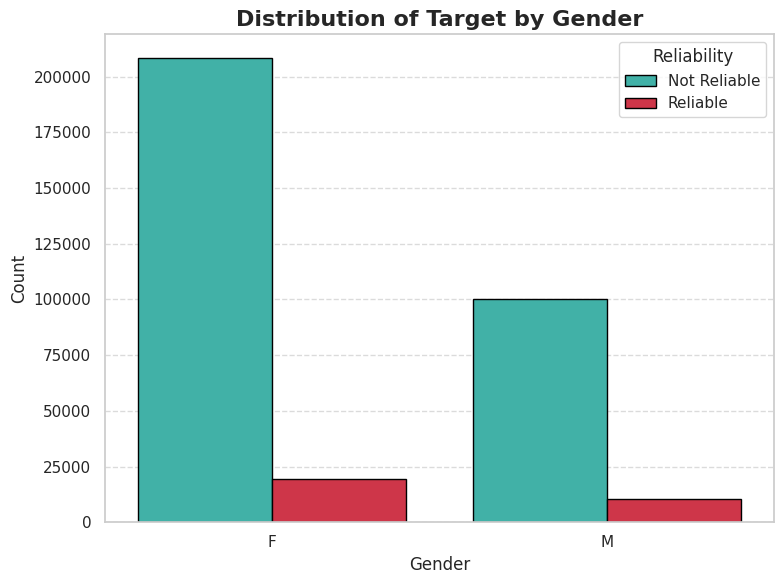

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=cgt,
    x="CODE_GENDER",
    y="count",
    hue="TARGET",
    palette=["#2ec4b6", "#e71d36"],
    edgecolor="black"
)

plt.title("Distribution of Target by Gender", fontsize=16, fontweight='bold')
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Reliable", "Reliable"], title="Reliability", loc="upper right")

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

From the gender analysis, it is highlighted that women outnumber men in the low credit rating category (0).

The percentage of women with high credit ratings is higher than that of men.

In [ ]:
nit_pivot = df.groupby(['NAME_INCOME_TYPE', 'TARGET']).size().unstack(fill_value=0)
print(nit_pivot)

TARGET                     0      1
NAME_INCOME_TYPE                   
Commercial associate   68678   9412
Pensioner              57841      0
State servant          24357   3756
Student                   14      3
Working               157814  16551


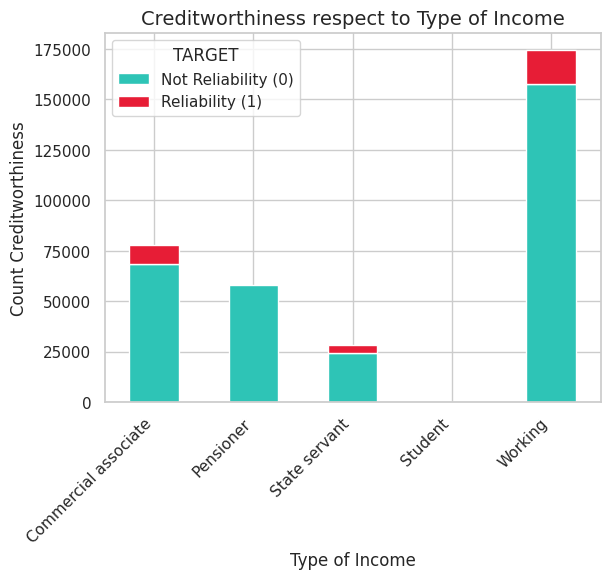

In [ ]:
_ = nit_pivot.plot(
    kind="bar",
    stacked=True,
    color=["#2ec4b6", "#e71d36"]
)

plt.title("Creditworthiness respect to Type of Income", fontsize=14)
plt.xlabel("Type of Income")
plt.ylabel("Count Creditworthiness")
plt.xticks(rotation=45, ha="right")
plt.legend(title="TARGET", labels=["Not Reliability (0)", "Reliability (1)"])
plt.show()

In [ ]:
foc = df.groupby(["FLAG_OWN_CAR","TARGET"]).size().reset_index(name="count")
print(foc)

  FLAG_OWN_CAR  TARGET   count
0            N       0  196064
1            N       1   17131
2            Y       0  112640
3            Y       1   12591


In [ ]:
net_pivot = df.groupby(["NAME_EDUCATION_TYPE","TARGET"]).size().unstack(fill_value=0)
print(net_pivot)

TARGET                              0      1
NAME_EDUCATION_TYPE                         
Academic degree                   200     32
Higher education                81616   9446
Incomplete higher               10725    662
Lower secondary                  3055    122
Secondary / secondary special  213108  19460


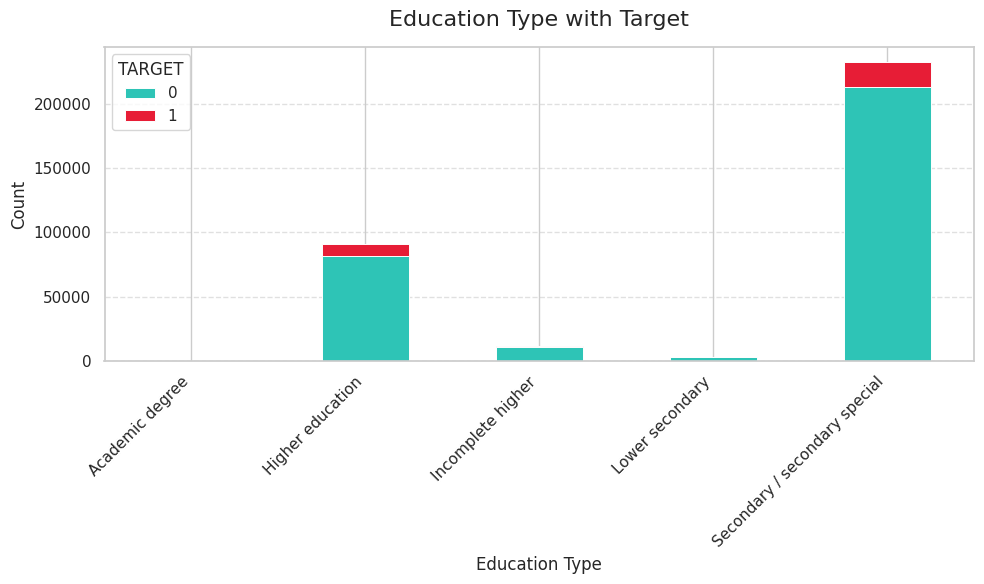

In [ ]:
colors = ["#2ec4b6", "#e71d36"]

ax = net_pivot.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    figsize=(10,6),
    linewidth=0.7
)

plt.title("Education Type with Target", fontsize=16, pad=15)
plt.xlabel("Education Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The data shows that people with a higher education and a special high school diploma tend to have higher creditworthiness.

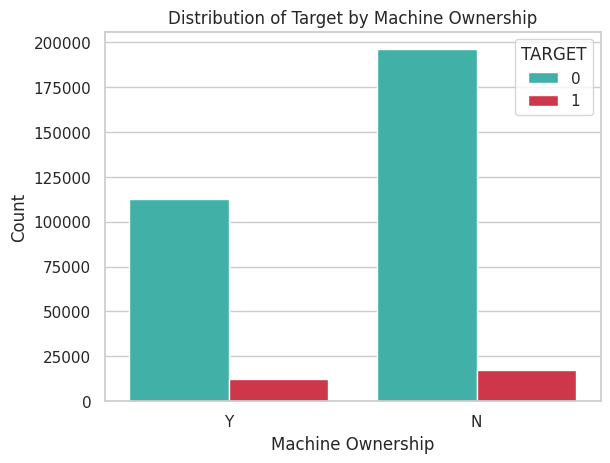

In [ ]:
palette = ["#2ec4b6", "#e71d36"]

sns.countplot(data=df, x="FLAG_OWN_CAR", hue="TARGET", palette=palette)
plt.title("Distribution of Target by Machine Ownership")
plt.xlabel("Machine Ownership")
plt.ylabel("Count")
plt.legend(title="TARGET", loc="upper right")
plt.show()

# 3. Pre-Modeling Data Preparation

In [ ]:
binary_columns = ["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]

le = LabelEncoder()
for col in binary_columns:
  df[col]= le.fit_transform(df[col])

In [ ]:
categorical_columns = ["NAME_INCOME_TYPE",
                       "NAME_EDUCATION_TYPE",
                       "NAME_FAMILY_STATUS",
                       "NAME_HOUSING_TYPE",
                       "OCCUPATION_TYPE"]

df = pd.get_dummies(df,columns = categorical_columns, drop_first=True).astype(int)

In [ ]:
df.describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff
count,338426.000000,338426.000000,338426.000000,338426.000000,3.384260e+05,338426.000000,338426.000000,338426.0,338426.000000,338426.000000,...,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000,338426.000000
mean,0.326544,0.370040,0.683479,0.428936,1.876684e+05,-15998.212897,60234.533869,1.0,0.211379,0.293302,...,0.080916,0.030843,0.170912,0.008235,0.002518,0.093527,0.004660,0.018373,0.134446,0.003679
std,0.468950,0.482816,0.465120,0.727991,1.107863e+05,4193.088539,138522.923248,0.0,0.408287,0.455276,...,0.272706,0.172892,0.376432,0.090374,0.050112,0.291170,0.068104,0.134297,0.341131,0.060541
min,0.000000,0.000000,0.000000,0.000000,2.554800e+04,-26636.000000,-17973.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.212302e+05,-19467.000000,-3116.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.628555e+05,-15623.000000,-1483.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,2.252080e+05,-12516.250000,-378.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,19.000000,7.071015e+06,-7566.000000,396498.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X = df.drop(["TARGET"], axis = 1).values
y = df["TARGET"].values

X.shape, y.shape

((338426, 48), (338426,))

In [ ]:
RANDOM_SEED= 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify= y)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train.shape , X_test.shape

((270740, 48), (67686, 48))

In [ ]:
X_train.mean() , X_train.std()

(np.float64(8.274662162801762e-18), np.float64(0.9895285072532212))

# 4. Models

In [ ]:
lr = LogisticRegression(class_weight="balanced", random_state=RANDOM_SEED)
lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)

y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

cm = confusion_matrix(y_test,y_pred_test)
print(cm)
print(f"*" * 60)
print(f"Train Report")
print(classification_report(y_train,y_pred_train))
print(f"*" * 60)
print(f"Test Report")
print(classification_report(y_test,y_pred_test))
print(f"*" * 60)
print("Train ROC-AUC:", (roc_auc_score(y_train, y_proba_train[:, 1])))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test[:, 1]))

[[50466 11276]
 [  689  5255]]
************************************************************
Train Report
              precision    recall  f1-score   support

           0       0.99      0.82      0.89    246962
           1       0.32      0.89      0.47     23778

    accuracy                           0.82    270740
   macro avg       0.65      0.85      0.68    270740
weighted avg       0.93      0.82      0.86    270740

************************************************************
Test Report
              precision    recall  f1-score   support

           0       0.99      0.82      0.89     61742
           1       0.32      0.88      0.47      5944

    accuracy                           0.82     67686
   macro avg       0.65      0.85      0.68     67686
weighted avg       0.93      0.82      0.86     67686

************************************************************
Train ROC-AUC: 0.918395683056969
Test ROC-AUC: 0.9197136764314211


In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

model= LogisticRegression(random_state=RANDOM_SEED, max_iter=500)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
y_pred_train_resampled = model.predict(X_train_resampled)

y_proba_train_smote = model.predict_proba(X_train)
y_proba_test_smote = model.predict_proba(X_test)

cm_smote = confusion_matrix(y_test,y_pred)
print(cm_smote)
print(f"*" * 60)
print(f"Train Report")
print(classification_report(y_train_resampled,y_pred_train_resampled))
print(f"*" * 60)
print(f"Test Report")
print(classification_report(y_test,y_pred))
print(f"*" * 60)
print("Train ROC-AUC:", roc_auc_score(y_train, y_proba_train_smote[:, 1]))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test_smote[:, 1]))

[[50678 11064]
 [  717  5227]]
************************************************************
Train Report
              precision    recall  f1-score   support

           0       0.89      0.82      0.85    246962
           1       0.83      0.90      0.86    246962

    accuracy                           0.86    493924
   macro avg       0.86      0.86      0.86    493924
weighted avg       0.86      0.86      0.86    493924

************************************************************
Test Report
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     61742
           1       0.32      0.88      0.47      5944

    accuracy                           0.83     67686
   macro avg       0.65      0.85      0.68     67686
weighted avg       0.93      0.83      0.86     67686

************************************************************
Train ROC-AUC: 0.9187825511550417
Test ROC-AUC: 0.9202140354995235


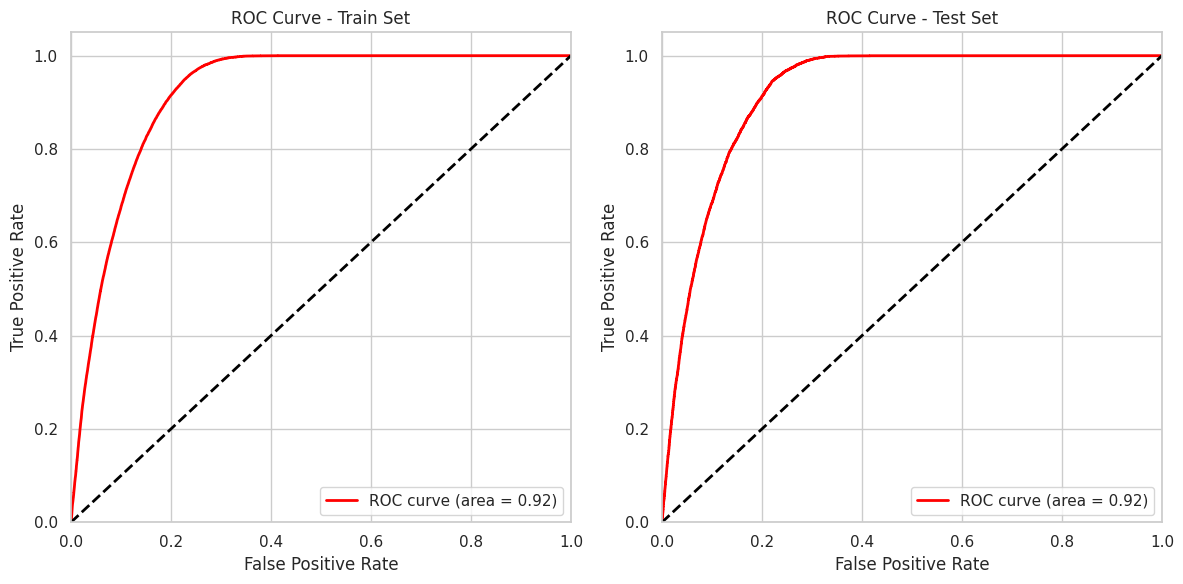

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_proba_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train Set')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=100,
                            max_features=0.8,
                            max_depth=5,
                            criterion="gini",
                            min_samples_split=5,
                            random_state=RANDOM_SEED)

In [ ]:
rf.fit(X_train_resampled, y_train_resampled)

y_pred_train_rf = rf.predict(X_train)
y_proba_train_rf = rf.predict_proba(X_train)[:, 1]

y_pred_test_rf = rf.predict(X_test)
y_proba_test_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
print(cm_rf)
print(f"*" * 60)
report_rf_train = classification_report(y_train, y_pred_train_rf)
print(report_rf_train)
print(f"*" * 60)
report_rf_test = classification_report(y_test, y_pred_test_rf)
print(report_rf_test)
print(f"*" * 60)
print("Train ROC-AUC:", roc_auc_score(y_train, y_proba_train_rf))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_test_rf))

[[58513  3229]
 [   75  5869]]
************************************************************
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    246962
           1       0.64      0.99      0.78     23778

    accuracy                           0.95    270740
   macro avg       0.82      0.97      0.87    270740
weighted avg       0.97      0.95      0.96    270740

************************************************************
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     61742
           1       0.65      0.99      0.78      5944

    accuracy                           0.95     67686
   macro avg       0.82      0.97      0.88     67686
weighted avg       0.97      0.95      0.96     67686

************************************************************
Train ROC-AUC: 0.9782841561681185
Test ROC-AUC: 0.9782995981454194


From the data obtained, we can see that the True Negatives are 58,512, the False Positives are 3,230, the False Negatives are 75 and the True Positives are 5,869.

The ROC-AUC value is 0.98 and we can say the model is good to distinguish two classes.

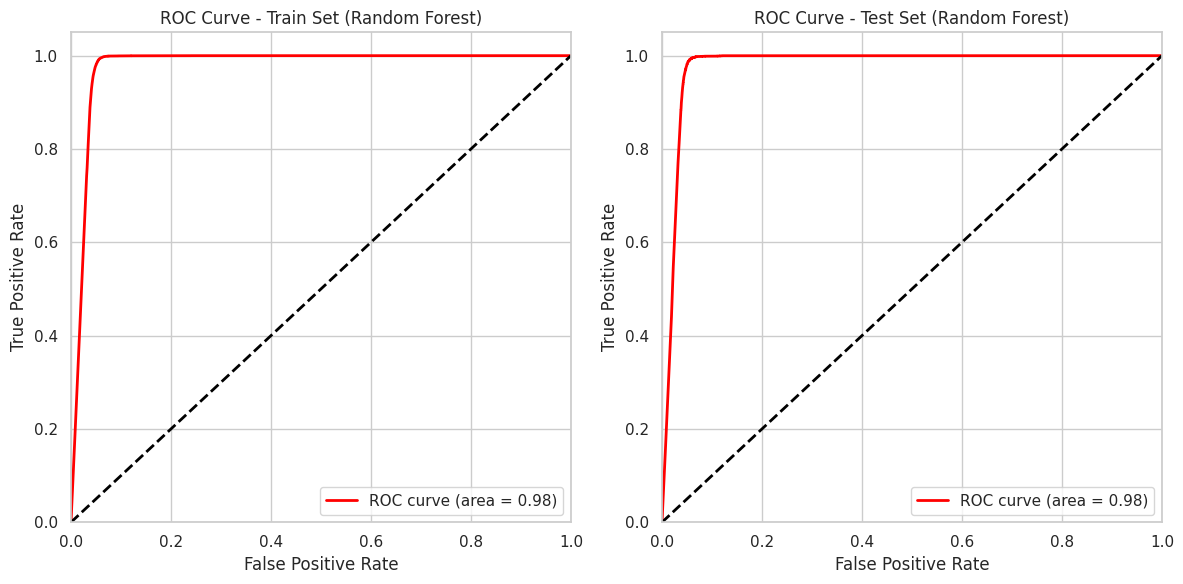

In [ ]:
fpr_train_rf, tpr_train_rf, thresholds_train_rf = roc_curve(y_train, y_proba_train_rf)
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

fpr_test_rf, tpr_test_rf, thresholds_test_rf = roc_curve(y_test, y_proba_test_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train_rf, tpr_train_rf, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train_rf)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train Set (Random Forest)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_test_rf, tpr_test_rf, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_rf)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (Random Forest)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
importances = rf.feature_importances_
features = df.drop(columns=["TARGET"]).columns
sorted_importances = sorted(zip(features,importances), key = lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in sorted_importances:
  print(f"{feature}: {importance:.2f}")

Feature Importance:
AMT_INCOME_TOTAL: 0.39
DAYS_BIRTH: 0.34
DAYS_EMPLOYED: 0.25
NAME_INCOME_TYPE_Pensioner: 0.01
OCCUPATION_TYPE_Pensioner: 0.01
CNT_CHILDREN: 0.00
NAME_EDUCATION_TYPE_Higher education: 0.00
CODE_GENDER: 0.00
NAME_EDUCATION_TYPE_Secondary / secondary special: 0.00
FLAG_PHONE: 0.00
CNT_FAM_MEMBERS: 0.00
NAME_EDUCATION_TYPE_Incomplete higher: 0.00
OCCUPATION_TYPE_High skill tech staff: 0.00
NAME_FAMILY_STATUS_Separated: 0.00
OCCUPATION_TYPE_Core staff: 0.00
FLAG_EMAIL: 0.00
OCCUPATION_TYPE_Drivers: 0.00
OCCUPATION_TYPE_Unknown: 0.00
OCCUPATION_TYPE_Managers: 0.00
FLAG_OWN_REALTY: 0.00
NAME_FAMILY_STATUS_Married: 0.00
NAME_INCOME_TYPE_State servant: 0.00
NAME_HOUSING_TYPE_Office apartment: 0.00
NAME_FAMILY_STATUS_Single / not married: 0.00
FLAG_WORK_PHONE: 0.00
NAME_INCOME_TYPE_Working: 0.00
NAME_HOUSING_TYPE_With parents: 0.00
NAME_HOUSING_TYPE_House / apartment: 0.00
OCCUPATION_TYPE_Security staff: 0.00
OCCUPATION_TYPE_Realty agents: 0.00
NAME_FAMILY_STATUS_Widow: 0.00
O

# 5. Results

Considering all the given variables, we can see that AMT_INCOME_TOTAL, DAYS_BIRTH and DAYS_EMPLOYED are the most influential in indicating whether the customer has a good credit rating.
AMT_INCOME_TOTAL (customer's total income) has the greatest weight. There is certainly a strong relationship between income and the probability of paying the installments on time.
DAYS_BIRTH has a lower weight than the previous variable but at the same time has a significant impact. We could say that the customer's age affects reliability.
DAYS_EMPLOYED has a fair impact. Having a job is an important factor in determining the reliability of a customer.
OCCUPATION_TYPE and NAME_INCOME_TYPE have a relatively low impact.

Based on the analysis performed, we can state that the main variables that affect credit reliability are: Annual Income, Age and Working Days.